# Image clustering with CLIP

In this notebook, we explore how to use CLIP and FAISS to cluster images.
We will apply the following steps:
* Install required packages
* Load a dataset (CIFAR10 here)
* Make 10 clusters as there are 10 classes in the dataset
* Display distribution of the 10 classes in the clusters

## Install required packages

In [ ]:
pip install transformers Pillow torch datasets matplotlib scikit-learn


## Install FAISS with GPU or CPU support

In [18]:
#Uncomment one of those, depending on your hardware and run to install faiss
#pip install faiss-gpu
#pip install faiss-cpu

## Load CLIP: model and processor using transformers

In [19]:
#Import packages
import torch
from PIL import Image
from transformers import AutoProcessor, CLIPModel, AutoImageProcessor, AutoModel, AutoTokenizer
import faiss
import numpy as np
import time

#Define device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

#Load CLIP model, processor and tokenizer
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

## Load CIFAR 10 dataset
We use this dataset as it has 10 pre-defined classes

Found cached dataset cifar10 (/home/user/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 936.02it/s]


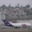

In [20]:
from datasets import load_dataset

#Load cifar10 dataset
dataset = load_dataset("cifar10")

#Display an image
display(dataset['train'][0]['img'])

## Extract the features of all images in the test set (10K images) and store them in a FAISS index

In [21]:
#Add a vector to FAISS index
def add_vector_to_index(embedding, index):
    #convert embedding to numpy
    vector = embedding.detach().cpu().numpy()
    #Convert to float32 numpy
    vector = np.float32(vector)
    #Normalize vector: important
    faiss.normalize_L2(vector)
    #Add to index
    index.add(vector)

#Extract features of a given image
def extract_features_clip(image):
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt").to(device)
        image_features = model.get_image_features(**inputs)
        return image_features

#FAISS index
index = faiss.IndexFlatL2(512)

#Process the dataset to extract all features and store in index
for image in dataset['test']:
    clip_features = extract_features_clip(image['img'])
    add_vector_to_index(clip_features,index)
    
#Write index locally. Not needed after but can be useful for future retrieval
faiss.write_index(index,"clip.index")

## Make 10 clusters

In [22]:
#Retrieve the vectors
vectors = index.reconstruct_n(0, 10000)

#Define clusters and parameters
x= vectors
ncentroids = 10
niter = 50
verbose = True
d = x.shape[1]

t0=time.time()
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
kmeans.train(x)
print('Clustering done in ', time.time()-t0)

cluster_assignments = kmeans.assign(vectors)
print(cluster_assignments)
clusters_ind = cluster_assignments[1]
print(clusters_ind)
print(clusters_ind.shape)

Sampling a subset of 2560 / 10000 for training
Clustering 2560 points in 512D to 10 clusters, redo 1 times, 50 iterations
  Preprocessing in 0.00 s
Clustering done in  0.07391953468322754
(array([0.13438654, 0.11428928, 0.15640831, ..., 0.12223983, 0.19230473,
       0.09824598], dtype=float32), array([4, 3, 3, ..., 6, 0, 2]))
[4 3 3 ... 6 0 2]
(10000,)


## Create a 10x10 matrix to store the distribution of the clusters

In [23]:
distribution = np.zeros((10, 10), dtype=int)
print(distribution)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [24]:
for vector_index,cluster_nb in enumerate(clusters_ind):
    label = dataset['test'][vector_index]['label']
    distribution[cluster_nb][label]+=1
 
print(distribution)


[[821   3   9   1   1   0   0   1  26   0]
 [  0   0  61  12 764  14   6  26   0   0]
 [  0   0   1   0   9   3   0 861   0   0]
 [ 15   0   2   0   0   0   0   0 912   6]
 [132  20 148 179 155 131 244  99  45  37]
 [ 13   0 102  41  59   6 736   1   2   1]
 [  0   0   3  19   2 780   2   8   0   0]
 [ 12 976   0   2   1   2   0   0  15 956]
 [  0   1   9 743   7  62   8   3   0   0]
 [  7   0 665   3   2   2   4   1   0   0]]


## Compute number of values in each clusters

In [25]:
row_sums = np.sum(distribution, axis=1)

# Print the result
print("Sum of each row:")
print(row_sums)

Sum of each row:
[ 862  883  874  935 1190  961  814 1964  833  684]


## Plot distribution of classes per cluster

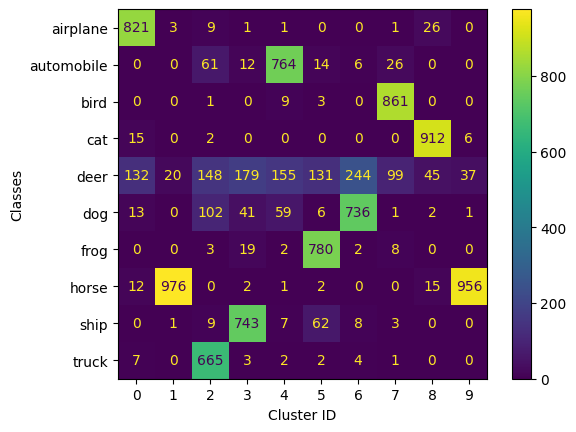

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=distribution)
disp.plot()
plt.xlabel('Cluster ID')
plt.ylabel('Classes')
labels = dataset["train"].features["label"].names
y = range(len(labels))
ticks = labels
plt.yticks(y, ticks)
plt.show()